In [2]:
import os
from langchain_openai import ChatOpenAI
from crewai import Agent, Task, Crew, Process
from langchain_openai import ChatOpenAI

/opt/anaconda3/envs/langchain/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
llm =ChatOpenAI(temperature = 0, model = "gpt-3.5-turbo-16k")

In [5]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [6]:
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate


class TopicSelectionParser(BaseModel):
    Topic: str = Field(description='Selected Topic')
    #Reasoning: str = Field(description='Reasoning behind topic selection')

parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [7]:
def function_1(state):
    print('-> Calling Agent ->')
    messages = state['messages']
    question = messages[-1]   # Fetching the user question
    
    template = """ Your task is to provide only the topic based on the user query. 
        Only output the topic among: [HTML,CSS]. Don't include reasoning. 
        Following is the user query:  {question}
        {format_instructions} """
    
    prompt = PromptTemplate(template=template,
                            input_variables=['question'],
                            partial_variables={"format_instructions": parser.get_format_instructions()}
                           )
    chain = prompt | llm | parser

    response = chain.invoke({"question": question, "format_instructions": parser.get_format_instructions()})
    print(response)

    return {"messages": [response.Topic]}

In [8]:
def router(state):
    print('-> Router ->')
    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)
    if 'Engineer' in last_message:
        return 'Engineer LLM Call'
    elif 'Critic' in last_message:
        return 'Critic LLM Call'
    else:
        return 'Planner LLM Call'

def function_2(state):
    print('-> Calling Engineer LLM ->')
    messages = state['messages']
    question = messages[0]  # Fetching the user question

    # Normal LLM call
    complete_query = "You are an Expert in HTML & CSS. Answer the following question with your coding knowledge. Following is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages": [response]}

def function_3(state):
    print('-> Calling Critic LLM ->')
    messages = state['messages']
    question = messages[0]  # Fetching the user question

    # Normal LLM call
    complete_query = "You are a code critic. Your only job is make a better suggestion to engineer about what engineer wrote. " + question
    response = llm.invoke(complete_query)
    return {"messages": [response]}

def function_4(state):
    print('-> Calling Planner LLM ->')
    messages = state['messages']
    question = messages[0]  # Fetching the user question

    # Normal LLM call
    complete_query = "Planner. Suggest a plan " + question
    response = llm.invoke(complete_query)
    return {"messages": [response]}



In [9]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)  # StateGraph with AgentState

graph.add_node("Engineer_LLM", function_2)
graph.add_node("Critic_LLM", function_3)
graph.add_node("Planner_LLM", function_4)

graph.set_entry_point("Planner_LLM")


graph.add_edge("Planner_LLM", "Engineer_LLM")
graph.add_edge("Engineer_LLM", "Critic_LLM")
graph.add_edge("Critic_LLM", END)


app = graph.compile()

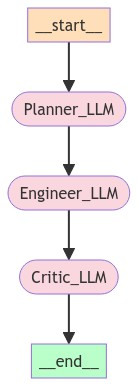

In [10]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [11]:
inputs = {"messages": ['<<button class="carousel-control-prev" type="button" data-bs-target="#carouselExample" data-bs-slide="Previous slider" alt="Previous slider">> Engineer, there is a problem in this HTML code. I want you to fix this.']}
out = app.invoke(inputs)
out['messages']

-> Calling Planner LLM ->
-> Calling Engineer LLM ->
-> Calling Critic LLM ->


['<<button class="carousel-control-prev" type="button" data-bs-target="#carouselExample" data-bs-slide="Previous slider" alt="Previous slider">> Engineer, there is a problem in this HTML code. I want you to fix this.',
 AIMessage(content='I apologize, but as a text-based AI, I am unable to view or modify HTML code directly. However, if you can provide me with the specific issue or error message you are encountering, I would be happy to assist you in troubleshooting and finding a solution.', response_metadata={'token_usage': {'completion_tokens': 53, 'prompt_tokens': 64, 'total_tokens': 117}, 'model_name': 'gpt-3.5-turbo-16k-0613', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-e0c2d9e3-70b1-4b6f-85cb-4c6ca8a5cb9c-0', usage_metadata={'input_tokens': 64, 'output_tokens': 53, 'total_tokens': 117}),
 AIMessage(content='The issue in the provided HTML code is with the "data-bs-slide" attribute value. The correct value for this attribute should be "prev" inste

In [13]:
inputs = {"messages": ['<<span style="color:#58E7E7;">> Engineer, there is a problem in this CSS code. I want you to fix this.']}
out = app.invoke(inputs)
out['messages']


-> Calling Planner LLM ->
-> Calling Engineer LLM ->
-> Calling Critic LLM ->


['<<span style="color:#58E7E7;">> Engineer, there is a problem in this CSS code. I want you to fix this.',
 AIMessage(content="Sure, I'd be happy to help you fix the CSS code. Could you please provide me with the code that needs to be fixed and let me know what the problem is?", response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 45, 'total_tokens': 81}, 'model_name': 'gpt-3.5-turbo-16k-0613', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-a1865db3-9193-4273-a0e8-4ab85bac854a-0', usage_metadata={'input_tokens': 45, 'output_tokens': 36, 'total_tokens': 81}),
 AIMessage(content="Sure, I'd be happy to help you fix the CSS code. Please provide me with the code that needs to be fixed and let me know what the problem is.", response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 62, 'total_tokens': 96}, 'model_name': 'gpt-3.5-turbo-16k-0613', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, i

In [15]:
inputs = {"messages": ['<<h4 class="heading">> Engineer, there is a problem in this HTML code. I want you to fix this.']}
out = app.invoke(inputs)
out['messages']

-> Calling Planner LLM ->
-> Calling Engineer LLM ->
-> Calling Critic LLM ->


['<<h4 class="heading">> Engineer, there is a problem in this HTML code. I want you to fix this.',
 AIMessage(content="Sure, I'd be happy to help you fix the problem in the HTML code. However, since you haven't provided any specific details about the issue or the code itself, I'll provide a general plan to help you troubleshoot and fix HTML code problems:\n\n1. Identify the problem: Start by understanding the specific issue you're facing with the HTML code. Is it not displaying correctly, causing errors, or behaving unexpectedly? Determine the symptoms and try to narrow down the problem.\n\n2. Review the code: Take a close look at the HTML code in question. Check for any obvious errors, such as missing tags, incorrect syntax, or typos. Pay attention to any specific areas or elements that might be causing the problem.\n\n3. Validate the code: Use an HTML validator tool to check the code for any errors or warnings. These tools can help identify issues that might not be immediately appare

In [16]:
inputs = {"messages": ['The "Background and foreground colors do not have sufficient contrast ratio" error means that the color contrast between a web part or text and the background is not sufficient. This error is often seen, especially in designs that do not comply with accessibility rates. Insufficient contrast can make text difficult or impossible to read, especially for users with distortion disorders.']}
out = app.invoke(inputs)
out['messages']

-> Calling Planner LLM ->
-> Calling Engineer LLM ->
-> Calling Critic LLM ->


['The "Background and foreground colors do not have sufficient contrast ratio" error means that the color contrast between a web part or text and the background is not sufficient. This error is often seen, especially in designs that do not comply with accessibility rates. Insufficient contrast can make text difficult or impossible to read, especially for users with distortion disorders.',
 AIMessage(content='Plan: Improving Contrast Ratio for Web Design\n\n1. Identify the areas with insufficient contrast: Start by reviewing your website or web application and identify the specific areas where the "Background and foreground colors do not have sufficient contrast ratio" error occurs. This could include text, buttons, icons, or any other elements that may be affected.\n\n2. Understand accessibility guidelines: Familiarize yourself with the accessibility guidelines, such as the Web Content Accessibility Guidelines (WCAG) 2.1, which provide specific recommendations for color contrast ratios

In [18]:
inputs = {"messages": ['The "Heading elements are not in a sequentially-descending order" error typically occurs when HTML heading tags (e.g., <h1>, <h2>, <h3>, etc.) are not used in the proper hierarchical sequence. This can cause accessibility issues and make it difficult for screen readers and other assistive technologies to properly navigate and interpret the content structure.']}
out = app.invoke(inputs)
out['messages']

-> Calling Planner LLM ->
-> Calling Engineer LLM ->
-> Calling Critic LLM ->


['The "Heading elements are not in a sequentially-descending order" error typically occurs when HTML heading tags (e.g., <h1>, <h2>, <h3>, etc.) are not used in the proper hierarchical sequence. This can cause accessibility issues and make it difficult for screen readers and other assistive technologies to properly navigate and interpret the content structure.',
 AIMessage(content='Plan: Fixing the "Heading elements are not in a sequentially-descending order" error\n\n1. Identify the web page or document where the error is occurring. This could be a specific HTML file or a content management system (CMS) where the content is being generated.\n\n2. Review the current heading structure of the page. Look for any instances where heading tags are not used in a sequentially-descending order (e.g., <h1> followed by <h3> instead of <h2>).\n\n3. Determine the correct hierarchical sequence for the headings. The heading structure should follow a logical order, with the main heading as <h1> and su